In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import feather
from Bio import SeqIO
from itertools import *
from operator import itemgetter
from functools import reduce
import pprint


%matplotlib inline
import matplotlib.pyplot as plt

# show more rows when displaying a DataFrame
pd.set_option('display.max_rows', 500)

sys.path.append(os.path.join(os.getenv('HOME')
                             , 'nu'
                             , 'jiping_research'
                             , 'nuclstm'
                             , 'nuclstm'))

from loaders import *
from train import *
from utils import *
from preprocessors import *
# from evaluation import *
from keras.initializers import RandomUniform, RandomNormal
from models import *

In [2]:
data_dir = os.path.join('/Users/fineiskid/nu/jiping_research/data')
data_file = 'unique_nucleosome_map.feather'
config_file = '/Users/fineiskid/nu/jiping_research/nuclstm/model_configs/gru_binary_sequence_config.json'

## Load NCP data, config file

In [3]:
loader = NcpLoader(data_dir)
nuc_df = loader.load(data_file)

train_chroms = list(range(1, 10))
val_chroms = list(range(10, 13))
test_chroms = list(range(13, 17))

print('Nucleosome occupancy percentage: {:10.4f}%'
      .format(100*np.sum(nuc_df['nucleosome'])/nuc_df.shape[0]))

print('Training set chromosomes: {0}'.format(train_chroms))
print('Validation set chromosomes: {0}'.format(val_chroms))
print('Test set chromosomes: {0}'.format(test_chroms))

Nucleosome occupancy percentage:     0.5616%
Training set chromosomes: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Validation set chromosomes: [10, 11, 12]
Test set chromosomes: [13, 14, 15, 16]


In [4]:
params = ConfigLoader(config_file).load()
pprint.pprint(params)

{'data_params': {'batch_size': 128,
                 'lookback': 250,
                 'no_one_class_samples': False,
                 'output_len': 250,
                 'shuffle': False,
                 'step_size': 250,
                 'target_position': 'all'},
 'model_params': {'class_weight': None,
                  'dense_params': {'activation': 'sigmoid',
                                   'hidden_units': 1,
                                   'regularization': {0: 0.0},
                                   'timedistributed': True},
                  'early_stopping': None,
                  'epochs': 250,
                  'final_layer_activation': 'sigmoid',
                  'rnn_params': {'activation': 'tanh',
                                 'bidirectional': True,
                                 'dropout': {0: 0.0, 1: 0.0},
                                 'flavor': 'gru',
                                 'hidden_units': [32, 64],
                                 'recurren

## Preprocess nucleosome positioning target data

In [5]:
nuc_df = preprocess_by_chromosome(nuc_df
                                  , target=params['model_params']['target']
                                  , method=params['preprocessor_params']['target']['method']
                                  , pad_len=params['preprocessor_params']['target']['pad_len'])
TARGET = 'nucleosome_padded'
nuc_df.head(5)

,Chr,pos,seq,Watson,Crick,NCP,NCP/noise,nucleosome,nucleosome_padded
0,chr1,1,C,0.0,0.0,0.0,0.0,0.0,0.0
1,chr1,2,C,2.0,0.0,0.0,0.0,0.0,0.0
2,chr1,3,A,6.0,0.0,0.0,0.0,0.0,0.0
3,chr1,4,C,14.0,0.0,0.0,0.0,0.0,0.0
4,chr1,5,A,9.0,0.0,0.0,0.0,0.0,0.0


Text(0.5,1,'Sample nucleosome data: chromsome chr4, positions 120000 - 120999')

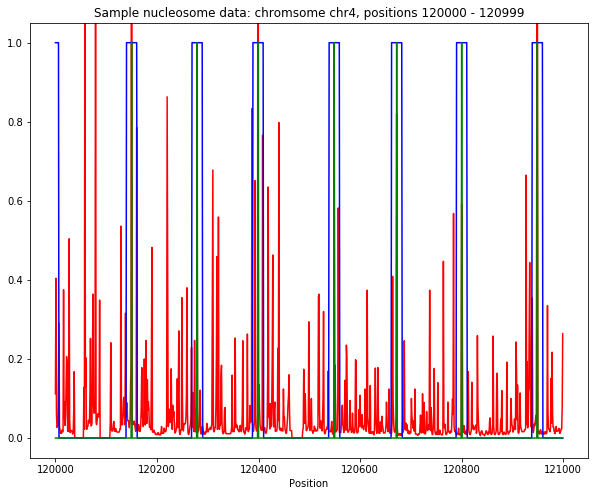

In [6]:
plot_chrom = 'chr4'
plot_idx = np.arange(120000, stop=121000)

fig, ax = plt.subplots(1, 1, figsize=[10, 8])
ax.plot(plot_idx, nuc_df[nuc_df.Chr == plot_chrom]['NCP/noise'].iloc[plot_idx], 'r-')
ax.plot(plot_idx, nuc_df[nuc_df.Chr == plot_chrom]['nucleosome_padded'].iloc[plot_idx], 'b-')
ax.plot(plot_idx, nuc_df[nuc_df.Chr == plot_chrom]['nucleosome'].iloc[plot_idx], 'g-')
ax.set_xlabel('Position')
ax.set_ylim([-0.05, 1.05])
ax.set_title('Sample nucleosome data: chromsome {0}, positions {1} - {2}'
                  .format(plot_chrom, plot_idx[0], plot_idx[-1]))

## Create data generators

In [7]:
flatten = (params['run_params']['model_type'].lower() in ['dense', 'covrnn'] and params['data_params']['output_len'] > 1
               and params['model_params']['rnn_params']['stateful'])

train_gen = gen_seq_scans(loader.subset_to_chromosomes(nuc_df
                                                       , chromosomes=train_chroms)
                          , lookback=params['data_params']['lookback']
                          , batch_size=params['data_params']['batch_size']
                          , target=TARGET
                          , target_position=params['data_params']['target_position']
                          , shuffle=params['data_params']['shuffle']
                          , step_size=params['data_params']['step_size']
                          , flatten_final_target_dim=flatten
                          , no_one_class_samples=params['data_params']['no_one_class_samples'])

val_gen = gen_seq_scans(loader.subset_to_chromosomes(nuc_df
                                                     , chromosomes=val_chroms)
                        , lookback=params['data_params']['lookback']
                        , batch_size=params['data_params']['batch_size']
                        , target=TARGET
                        , target_position=params['data_params']['target_position']
                        , shuffle=params['data_params']['shuffle']
                        , step_size=params['data_params']['step_size']
                        , flatten_final_target_dim=flatten
                        , no_one_class_samples=params['data_params']['no_one_class_samples'])

test_df = loader.subset_to_chromosomes(nuc_df
                                       , chromosomes=test_chroms)
test_gen = gen_seq_scans(test_df
                        , lookback=params['data_params']['lookback']
                        , batch_size=params['data_params']['batch_size']
                        , target=TARGET
                        , target_position=params['data_params']['target_position']
                        , step_size=params['data_params']['lookback']
                        , flatten_final_target_dim=flatten
                        , test_set=True)

In [8]:
tmp_val_x, tmp_val_y = next(val_gen)

print('tmp_val_x.shape = {0}'.format(tmp_val_x.shape))
print('tmp_val_y.shape = {0}'.format(tmp_val_y.shape))

tmp_val_x.shape = (128, 250, 4)
tmp_val_y.shape = (128, 250, 1)


## Build an LSTM model

In [9]:
from keras.models import Sequential
from keras.layers import *
from keras.regularizers import l1_l2
from loaders import *
from model_helpers import *
from functools import partial
import os


class ModelBuilder():

    def __init__(self, config_file=None, config=None):

        if isinstance(config, dict):
            self.config = config
        elif config_file:
            self.config = ConfigLoader(config_file).load()
        else:
            raise ValueError('Must specify either config_file or config (a dictionary).')

        self.model_type = validate_model_type(self.config['run_params']['model_type'])
        self.lookback = self.config['data_params']['lookback']
        self.batch_size = self.config['data_params']['batch_size']
        self.output_len = self.config['data_params']['output_len']

        self.xtra_metric = self.config['model_params'].get('xtra_metric'
                                                           , determine_xtra_metric(self.config['optimizer_params']['loss']))


    @staticmethod
    def int_2_list(x):
        if isinstance(x, list):
            return x
        else:
            return [x]


    def build_rnn(self, covnet=None):

        rnn_params = self.config['model_params']['rnn_params']

        hidden_units = self.int_2_list(rnn_params['hidden_units'])
        n_hidden_layers = len(hidden_units)

        # if not timedistributed and we're on the last hidden layer in the network: return_sequences = False
        timedistributed = self.config['model_params']['dense_params']['timedistributed']
        stateful = rnn_params['stateful']
        bidirectional = rnn_params['bidirectional']

        # define main hidden layer
        intermediate_layer = partial(LSTM if rnn_params['flavor'] == 'lstm' else GRU
                                     , activation=rnn_params['activation']
                                     , use_bias=True
                                     , return_sequences=True
                                     , stateful=rnn_params['stateful'])

        if not timedistributed:
            final_hidden_layer = partial(LSTM if rnn_params['flavor'] == 'lstm' else GRU
                                         , activation=rnn_params['activation']
                                         , use_bias=True
                                         , stateful=rnn_params['stateful'])
        else:
            final_hidden_layer = intermediate_layer

        if rnn_params.get('initializer', None):
            intermediate_layer = partial(intermediate_layer, kernel_initializer=rnn_params.get('initializer'))
            final_hidden_layer = partial(final_hidden_layer, kernel_initializer=rnn_params.get('initializer'))

        # initialize either an RNN or a covnet-RNN hybrid.
        m = covnet if covnet else Sequential()

        for i in range(n_hidden_layers):
            neurons = hidden_units[i]
            dropout = rnn_params['dropout'][i]
            recurrent_dropout = rnn_params['recurrent_dropout'][i]
            reg_penalty = rnn_params['regularization'][i]

            if i == 0:
                l = intermediate_layer if n_hidden_layers > 1 else final_hidden_layer

                if stateful:
                    if not covnet:
                        if bidirectional:
                            m.add(Bidirectional(l(units=neurons
                                                  , dropout=dropout
                                                  , recurrent_dropout=recurrent_dropout
                                                  , kernel_regularizer=l1_l2(reg_penalty, reg_penalty))
                                                , batch_input_shape=(self.batch_size, self.lookback, 4)))
                        else:
                            m.add(l(units=neurons
                                    , dropout=dropout
                                    , recurrent_dropout=recurrent_dropout
                                    , kernel_regularizer=l1_l2(reg_penalty, reg_penalty)
                                    , batch_input_shape=(self.batch_size, self.lookback, 4)))
                    else:
                        if bidirectional:
                            m.add(Bidirectional(l(units=neurons
                                                  , dropout=dropout
                                                  , recurrent_dropout=recurrent_dropout
                                                  , kernel_regularizer=l1_l2(reg_penalty, reg_penalty))))
                        else:
                            m.add(l(units=neurons
                                    , dropout=dropout
                                    , recurrent_dropout=recurrent_dropout))
                else:
                    if not covnet:
                        if bidirectional:
                            m.add(Bidirectional(l(units=neurons
                                                  , dropout=dropout
                                                  , recurrent_dropout=recurrent_dropout
                                                  , kernel_regularizer=l1_l2(reg_penalty, reg_penalty))
                                                , input_shape=(self.lookback, 4)))
                        else:
                            m.add(l(units=neurons
                                    , dropout=dropout
                                    , recurrent_dropout=recurrent_dropout
                                    , kernel_regularizer=l1_l2(reg_penalty, reg_penalty)
                                    , input_shape=(self.lookback, 4)))
                    else:
                        if bidirectional:
                            m.add(Bidirectional(l(units=neurons
                                                  , dropout=dropout
                                                  , recurrent_dropout=recurrent_dropout
                                                  , kernel_regularizer=l1_l2(reg_penalty, reg_penalty))))
                        else:
                            m.add(l(units=neurons
                                    , dropout=dropout
                                    , recurrent_dropout=recurrent_dropout
                                    , kernel_regularizer=l1_l2(reg_penalty, reg_penalty)))

            else:
                l = intermediate_layer if i < (n_hidden_layers - 1) else final_hidden_layer

                if bidirectional:
                    m.add(Bidirectional(l(units=neurons
                                          , dropout=dropout
                                          , recurrent_dropout=recurrent_dropout
                                          , kernel_regularizer=l1_l2(reg_penalty, reg_penalty))))
                else:
                    m.add(l(units=neurons
                            , dropout=dropout
                            , recurrent_dropout=recurrent_dropout
                            , kernel_regularizer=l1_l2(reg_penalty, reg_penalty)))

        return m


    def build_dense(self):

        dense_params = self.config['model_params']['dense_params']

        hidden_units = self.int_2_list(dense_params['hidden_units'])

        m = Sequential()
        m.add(Flatten(input_shape=(self.lookback, 4)))

        for i in len(hidden_units):
            reg_penalty = dense_params['regularization'][i]
            m.add(Dense(hidden_units[i]
                        , activation=dense_params['activation']
                        , kernel_regularizer=l1_l2(reg_penalty, reg_penalty)
                        , use_bias=True))

        return m


    def build_covrnn(self):

        covnet_params = self.config['model_params']['covnet_params']

        filters = self.int_2_list(covnet_params['filters'])
        kernel_sizes = self.int_2_list(covnet_params['kernel_sizes'])
        pool_sizes = self.int_2_list(covnet_params['pool_sizes'])
        strides = self.int_2_list(covnet_params['strides'])

        m = Sequential()

        for i in range(len(filters)):
            cov_layer = partial(Conv1D
                                , filters=filters[i]
                                , kernel_size=kernel_sizes[i]
                                , strides=strides[i]
                                , padding='valid'
                                , activation=covnet_params['activation'])
            if i == 0:
                if self.config['model_params']['rnn_params']['stateful']:
                    cov_layer = partial(cov_layer
                                        , batch_input_shape=(self.batch_size, self.lookback, 4))
                else:
                    cov_layer = partial(cov_layer
                                        , input_shape=(self.lookback, 4))

            if covnet_params.get('initializer', None):
                cov_layer = partial(cov_layer, kernel_initializer=covnet_params.get('initializer'))

            m.add(cov_layer())
            m.add(MaxPooling1D(pool_sizes[i]))

        m = self.build_rnn(covnet=m)

        return m


    def build(self):

        if self.model_type == 'rnn':
            m = self.build_rnn()
        elif self.model_type == 'covrnn':
            m = self.build_covrnn()
        elif self.model_type == 'dense':
            m = self.build_dense()

        # figure out how many neurons comprise the final dense layer of the model.
        timedistributed = self.config['model_params']['dense_params']['timedistributed']
        final_neurons = self.output_len

        # construct the model's output layer.
        if self.config['data_params']['target_position'] == 'all' and self.model_type == 'rnn':
            final_neurons = 1

        reg_dict = self.config['model_params']['dense_params']['regularization']
        reg_penalty = reg_dict[max(reg_dict.keys())]
        if self.config['model_params']['dense_params'].get('initializer', None):
            dense_layer = Dense(final_neurons
                                , activation=self.config['model_params']['final_layer_activation']
                                , kernel_initializer=self.config['model_params']['dense_params']['initializer']
                                , kernel_regularizer=l1_l2(reg_penalty, reg_penalty)
                                , use_bias=True)
        else:
            dense_layer = Dense(final_neurons
                                , activation=self.config['model_params']['final_layer_activation']
                                , kernel_regularizer=l1_l2(reg_penalty, reg_penalty)
                                , use_bias=True)

        if timedistributed:
            m.add(TimeDistributed(dense_layer))
        else:
            m.add(dense_layer)

        m.compile(loss=self.config['optimizer_params']['loss']
                  , optimizer=self.config['optimizer_params']['optimizer']
                  , metrics=[self.xtra_metric])

        return m


In [10]:
model_builder = ModelBuilder(config=params)
m = model_builder.build()
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 250, 64)           7104      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 250, 128)          49536     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 250, 1)            129       
Total params: 56,769
Trainable params: 56,769
Non-trainable params: 0
_________________________________________________________________


In [11]:
x_batch, y_batch = next(train_gen)

tr_loss, tr_metric = m.train_on_batch(x_batch
                                      , y=y_batch)

In [ ]:
# test_df = pd.DataFrame({'seq': ['A', 'A', 'C', 'A', 'T', 'G', 'A', 'C', 'G', 'A', 'T', 'G']
#                         , 'Chr': ['chr1'] * 6 + ['chr2'] * 6
#                         , 'pos': [0, 1, 2, 10, 11, 12] + list(range(100, 106))
#                         , 'nucleosome_padded': [0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.]})

# test_gen = gen_seq_scans(test_df,
#                          target='nucleosome_padded',
#                          lookback=1,
#                          shuffle=True,
#                          batch_size=1,
#                          step_size=1,
#                          target_position='all',
#                          flatten_final_target_dim=False,
#                          test_set=True,
#                          return_idx=True)
# y_idxs = list()
# for _ in range(1000):
#     tmp_x, tmp_y, idx = next(test_gen)
#     print(tmp_x)
#     print(tmp_y)
#     print(idx)
#     y_idxs.extend(idx)
    
# np.unique(y_idxs)

# tmp_x, tmp_y, idx = next(test_gen)
# print(tmp_x)
# print(tmp_y)
# print(idx)
# print(nuc_df.iloc[idx])

In [68]:
def extract_preds_from_test_set(gen, model, reset_every_n=1):
    """
    Run a model on specified number of batches extracted from a generator object.

    :param gen: generator object that returns a batch of (test set samples, test set targets).
    Generator should come from train.gen_seq_scans(..., test_set=True) so that batches are created sequentially.
    :param model: keras.models.Sequential model object
    :param n_pos: int quantity of total base positions spanned during test set evaluation
    :return: y, preds 2-tuple of arrays, the original target array (y) and the
    model predicted array (preds)
    """
    y = list()
    preds = list()
    idx = list()

    proceed = True
    batch_ctr = 0

    while proceed:
        if (batch_ctr % 10 == 0) and (batch_ctr > 0):
            print('batch number {0}, total predictions made = {1}'.format(batch_ctr, len(y)))

        # if reset_every_n is an integer, reset model every n batches.
        if isinstance(reset_every_n, int):
            for _ in range(reset_every_n):
                x_batch, y_batch, idx_batch = next(gen)

                preds_batch = model.predict(x_batch
                                            , batch_size=x_batch.shape[0])

                y += y_batch.ravel().tolist()
                preds += preds_batch.ravel().tolist()
                idx += idx_batch

            model.reset_states()

        # otherwise, assume model does not have a state that needs to be managed.
        else:
            x_batch, y_batch, idx_batch = next(gen)

            preds_batch = model.predict(x_batch
                                        , batch_size=x_batch.shape[0])

            y += y_batch.ravel().tolist()
            preds += preds_batch.ravel().tolist()
            idx += idx_batch

        # check wheter or not any batch indices are repeated. If they are,
        # this means that batches have reset to the beginning of the test set
        # as the entire test set has been covered.
        proceed = len(set(idx)) == len(idx)
        batch_ctr += 1

    # remove duplicate predictions and arrange predictions in genome order.
    preds_df = DataFrame({'y': y
                          , 'preds': preds
                          , 'idx': idx})
    preds_df.drop_duplicates(subset=['idx']
                             , inplace=True)
    preds_df.sort_values(['idx']
                         , inplace=True)
    preds_df.reset_index(drop=True
                         , inplace=True)

    return preds_df

In [69]:
preds_df = extract_preds_from_test_set(test_gen, model=m, reset_every_n=1)

batch number 10, total predictions made = 320000
batch number 20, total predictions made = 640000
batch number 30, total predictions made = 960000
batch number 40, total predictions made = 1280000
batch number 50, total predictions made = 1600000
batch number 60, total predictions made = 1920000
batch number 70, total predictions made = 2240000
batch number 80, total predictions made = 2560000
batch number 90, total predictions made = 2880000
batch number 100, total predictions made = 3200000
batch number 110, total predictions made = 3520000


In [76]:
preds_df.head()

,idx,preds,y
0,0,0.501147,0.0
1,1,0.506541,0.0
2,2,0.491165,0.0
3,3,0.493963,0.0
4,4,0.483754,0.0


In [79]:
test_df['idx'] = test_df.index.values
test_df = test_df.merge(preds_df
                        , how='inner'
                        , on='idx')

test_df.drop(['idx']
             , axis=1
             , inplace=True)

In [86]:
preds_df.drop(['idx']
                     , axis=1)

,nuclstm_preds,y
0,0.501147,0.0
1,0.506541,0.0
2,0.491165,0.0
3,0.493963,0.0
4,0.483754,0.0
5,0.489522,0.0
6,0.481016,0.0
7,0.487531,0.0
8,0.479351,0.0
9,0.486196,0.0
